traditional PINNs, input: (x,y)
f=0.


Start training on device: cpu
Epoch     0 | Loss 5.440e-01 | PDE 8.576e-04 | BC 5.432e-01 | relL2 1.093e+00
Epoch   200 | Loss 5.638e-02 | PDE 1.252e-03 | BC 5.513e-02 | relL2 2.262e-01
Epoch   400 | Loss 5.461e-02 | PDE 8.491e-04 | BC 5.376e-02 | relL2 2.229e-01
Epoch   600 | Loss 5.128e-02 | PDE 2.284e-03 | BC 4.900e-02 | relL2 2.108e-01
Epoch   800 | Loss 5.094e-02 | PDE 2.257e-03 | BC 4.868e-02 | relL2 2.101e-01
Epoch  1000 | Loss 5.056e-02 | PDE 2.247e-03 | BC 4.831e-02 | relL2 2.096e-01
Epoch  1200 | Loss 5.002e-02 | PDE 2.240e-03 | BC 4.778e-02 | relL2 2.086e-01
Epoch  1400 | Loss 4.926e-02 | PDE 2.185e-03 | BC 4.707e-02 | relL2 2.074e-01
Epoch  1600 | Loss 4.838e-02 | PDE 2.247e-03 | BC 4.614e-02 | relL2 2.058e-01
Epoch  1800 | Loss 4.764e-02 | PDE 2.330e-03 | BC 4.531e-02 | relL2 2.045e-01
Epoch  2000 | Loss 4.705e-02 | PDE 2.339e-03 | BC 4.471e-02 | relL2 2.036e-01
Epoch  2200 | Loss 4.656e-02 | PDE 2.281e-03 | BC 4.428e-02 | relL2 2.029e-01
Epoch  2400 | Loss 4.593e-02 | PDE

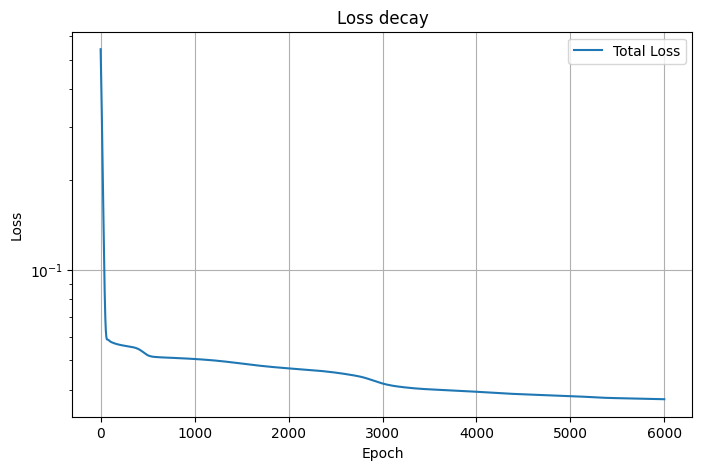

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# 邊界取點直接在裂縫上取點
# ---- Settings ----
torch.set_default_dtype(torch.float64)   # use double for better derivative precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain: square [-1,1]^2 with crack along y=0 for x in [0,1)
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0

# Training hyperparams
N_f = 4000       # collocation points
N_b_outer = 800  # boundary points on outer square
N_b_crack = 300  # boundary points on crack faces
epochs = 6000
lr = 1e-3
lambda_bc = 1.0   # weight for BC loss
eps_r = 1e-6        # avoid r=0

# ---- Utility functions ----
def compute_phi(x, y):
    r = torch.sqrt(x**2 + y**2).clamp(min=eps_r)
    return torch.sqrt(0.5 * (r - x))


# ---- Neural network ----
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)  # no activation on last
        return z
# ---- Derivatives & Laplace ----
def compute_laplace_u(model, x, y):
    inp = torch.cat([x, y], dim=1).to(device)
    inp.requires_grad_(True)
    u = model(inp)
    grads = torch.autograd.grad(u, inp, torch.ones_like(u),
                                create_graph=True)[0]
    u_x = grads[:,0:1]
    u_y = grads[:,1:2]
    u_xx = torch.autograd.grad(u_x, inp, torch.ones_like(u_x),
                               create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y, inp, torch.ones_like(u_y),
                               create_graph=True)[0][:,1:2]
    lap = u_xx + u_yy
    return lap

# ---- Data sampling ----
def sample_collocation(N):
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN
    mask_crack = (torch.abs(y) < 1e-8) & (x >= 0.0)  # remove points on crack
    mask = ~mask_crack
    x = x[mask][:N]
    y = y[mask][:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []
    # left (x=-1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MIN)
    # right (x=1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MAX)
    # bottom (y=-1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    # top (y=1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_crack_boundary(N):
    # 在 0 < x <= 1 取 N 個均勻點，避開 x=0
    x_vals = torch.linspace(0, 1, N + 1)[1:].unsqueeze(1).to(device)  # 忽略 x=0
    y_vals = torch.zeros_like(x_vals).to(device)  # y=0

    return x_vals, y_vals

# ---- Build model ----
layers = [2, 64, 1]  # inputs: x,y
model = MLP(layers).to(device)

# ---- Training data ----
x_f, y_f = sample_collocation(N_f)
x_b_out, y_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack = sample_crack_boundary(N_b_crack)

# boundary values: phi on boundaries
with torch.no_grad():
    phi_b_out = compute_phi(x_b_out, y_b_out)
    g_b_out = phi_b_out.clone()
    phi_b_crack = compute_phi(x_b_crack, y_b_crack)
    g_b_crack = phi_b_crack.clone()
    

# concatenate all boundary points
x_b = torch.cat([x_b_out, x_b_crack], dim=0)
y_b = torch.cat([y_b_out, y_b_crack], dim=0)
g_b = torch.cat([g_b_out, g_b_crack], dim=0)

# f = 0
f_val = torch.zeros_like(x_f).to(device)

# ---- Optimizer ----
optimizer = optim.Adam(model.parameters(), lr=lr)

# ---- Loss history ----
loss_history = []
relL2_history = []

# ---- Training loop ----
def relative_L2_error(model, ntest=10000):
    # compute on a uniform grid (excluding crack)
    nx = int(np.sqrt(ntest))
    xs = np.linspace(X_MIN, X_MAX, nx)
    ys = np.linspace(Y_MIN, Y_MAX, nx)
    Xg, Yg = np.meshgrid(xs, ys)
    Xg = Xg.flatten()[:,None]
    Yg = Yg.flatten()[:,None]
    x_test = torch.from_numpy(Xg).to(device).double()
    y_test = torch.from_numpy(Yg).to(device).double()
    # mask crack
    mask = ~((torch.abs(y_test) < 1e-8) & (x_test >= 0.0))
    x_test = x_test[mask]
    y_test = y_test[mask]
    with torch.no_grad():
        phi_test = compute_phi(x_test, y_test)
        x_test = x_test.view(-1,1)
        y_test = y_test.view(-1,1)
        phi_test = phi_test.view(-1,1)
        # model predict u_N
        inp = torch.cat([x_test, y_test], dim=1)
        u_pred = model(inp)
        u_true = phi_test
        num = torch.norm((u_pred - u_true).cpu())
        den = torch.norm(u_true.cpu())
        return (num / den).item()

print("Start training on device:", device)
for ep in range(epochs):
    optimizer.zero_grad()
    # PDE loss
    lap_u = compute_laplace_u(model, x_f, y_f)  # shape (N_f,1)
    residual = -lap_u  # f=0
    loss_pde = torch.mean(residual**2)

    # boundary loss
    phi_b = compute_phi(x_b, y_b)
    inp_bc = torch.cat([x_b, y_b], dim=1)
    u_bc = model(inp_bc)
    loss_bc = torch.mean((u_bc - g_b)**2)

    loss = loss_pde + lambda_bc * loss_bc
    loss.backward()
    optimizer.step()

    # 紀錄 loss
    loss_history.append(loss.item())

    if ep % 200 == 0 or ep == epochs-1:
        relL2 = relative_L2_error(model, ntest=4096)
        relL2_history.append((ep, relL2))
        print(f"Epoch {ep:5d} | Loss {loss.item():.3e} | PDE {loss_pde.item():.3e} | BC {loss_bc.item():.3e} | relL2 {relL2:.3e}")

print("Training finished.")
# final error
relL2 = relative_L2_error(model, ntest=10000)
print("Final relative L2 error:", relL2)

# ---- 畫 Loss 曲線 ----
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss decay")
plt.grid(True)
plt.show()


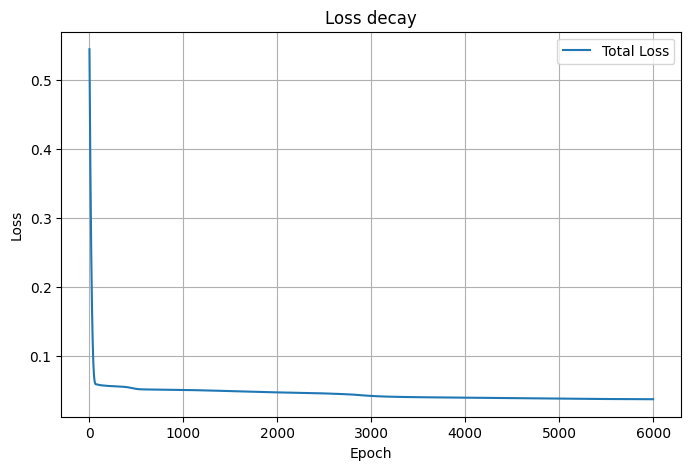

In [4]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss decay")
plt.grid(True)
plt.show()
